# Choosing a baseline model
In this section we discuss what is usually the first stage in tackling an imbalanced classfication problem, namely, to choose a good enough baseline model so further modelling developments are to be compared with this **baseline** model. The discussion can be guided by the following driving questions:
* What is the effect of class imbalance on different classification algorithms?
* Is class imbalance really a problem when there is enough data?
* What is the best benchmark model to start with? What does "best" actually mean in this situation?
* What can be done to mitigate the effect of imbalance on specific algorithms?

## Methodology
We intend to study the behavior (in terms of binary classification metrics) of different classification algorithms under various imbalance scenarios.
At this point we won't pay too much attention on optimizing the model's parameters. Rather, we will work with the vanilla versions of the models as we are interested in finding a "quick" generic approach to solving an imbalanced binary classification problem. 

The classical algorithm used for solving a binary classification problem is the Logistic Regression (citation needed!), two types of regularization (L1 and L2) will be considered to see the effect of regularization in the imbalanced case. On the other hand, it is also common to use tree-based ensemble methods to construct a model for binary classification. Thus, it is natural to consider a couple of Tree ensemble algorithms, such as Random Forests and Gradient Boosting Machines for our experiments. 

Three datasets will be used for the experiments, namely, we will test the algorithms on a synthetic dataset and on a couple of real dataset from which we can sample observations such that the class imbalance ratio can be changed at will. 

In [270]:
# basics
import sys
import joblib
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.auto import tqdm
from itertools import product

# plotting
import matplotlib
from matplotlib import pyplot as plt

# sklearn
from sklearn.datasets import make_classification

## Data
Let us begin by constructing the synthetic dataset, to do this we can use the `make_classification` function from scikit-learn [see here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html). This function allow us to quickly build a synthetic dataset for binary classification with some specificities such as the sample size, the number of informative features and the actual imbalance ratio, to name a few. 
### Synthetic Dataset (`make_classification`)
To easen the use of such function we will write a very simple wrapper that uses the `make_classification` function and returns a pandas dataframe with the actual synthetic dataset such that we can simply pass the class imbalance level as the `imbalance` parameter.

In [2]:
def create_imbalanced_binary_classification(n_samples: int = 1000, 
                                            n_features: int = 4,
                                            n_informative: int = None, 
                                            imbalance: float = 0.1,
                                            random_state: int = 42,
                                            class_sep : float = 1.0) -> pd.DataFrame:
    """Creates an imbalanced dataset for binary classification
    Parameters
    ----------
    n_samples: int, default = 1000,
            number of samples to generate
    n_features: int default = 4,
            number of features (not all are informative)
    n_informative: int default = None,
            number of informative features
            if none is specified floor(n_features/2) 
            will be taken
    imbalance: float, default = 0.1
            proportion of the minority class
    random_state: int, default = 42
    class_sep: float, default = 1.0
        The larger the value the easier the classification task
    Returns
    -------
    data: pd.DataFrame,
        dataframe with n_features + 1 columns
    """
    if n_informative == None:
        n_informative = int(n_features/2)
    weights = [1 - imbalance, imbalance]
    X, y = make_classification(n_samples = n_samples,
                                n_features = n_features,
                                n_classes=2,
                                n_informative = n_informative,
                                weights = weights,                
                                random_state = random_state,
                                class_sep = class_sep)
    column_names = [ f'feature_{i}' for i in np.arange(n_features)]      
    data = pd.concat([pd.DataFrame(X, columns = column_names), pd.DataFrame(y, columns = ['target'])], axis = 1)
    return data, column_names

To see how this function works, let us quickly build a dataset and visualize their features:

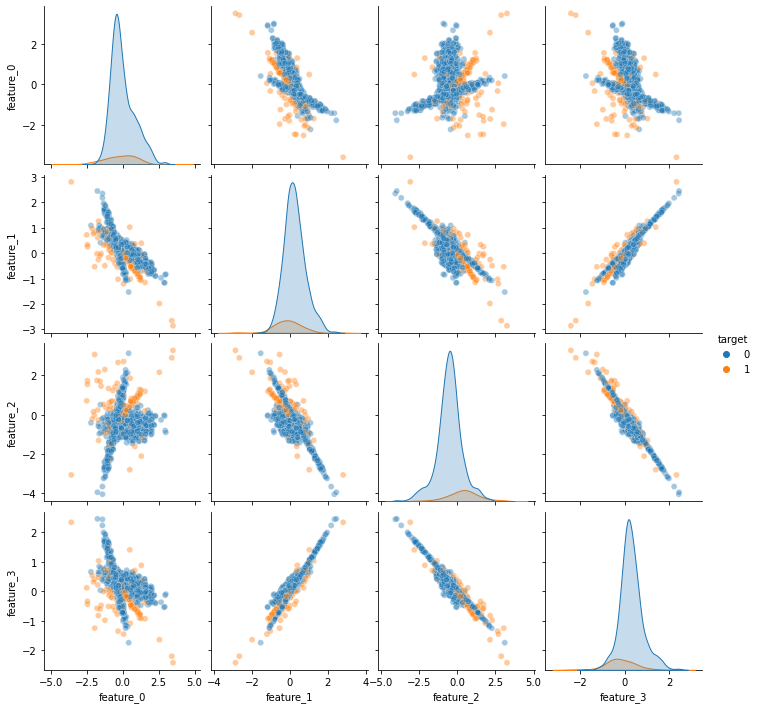

In [262]:
n_samples = 10**3
n_features = 4
imbalance = 0.1
n_informative = 2
class_sep = 0.5
data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
sns.pairplot(data, hue = 'target', plot_kws = {'alpha' : 0.4})
plt.show()


### Real Life Dataset I : **Census Income**
Additionally, we collected two *real-life* datasets. The first one is related to a classification task that asks for predicting whether a subject's income exceeds 50K USD/yr based on census data. Also known as "Census Income" dataset that can be found [here](https://archive-beta.ics.uci.edu/ml/datasets/adult).

The target is defined as whether the income is greater than 50k USD. The covariates are (mostly) categorical features related to census data, so we will have to apply some feature processing before we can actually use the data. Since our discussion is centered on the binary classification problem as a whole we will not spend too much time trying to choose the best way to encode these variables. Rather, we will just apply a **one hot encoding** technique to transform the categorical features into mumerical ones. To do that, we use scikit-learn's `OneHotEncoder` object [see here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html). Let us then load the dataset and perform the encoding.

In [55]:
# Census-income dataset
census_df = pd.read_csv('../data/adult.data', header= None)

census_col_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', \
                    'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', \
                    'native-country']
census_df.columns = census_col_names + ['income']
# encode the target label
census_df['target'] = (census_df.income == ' >50K').astype(int)


In [263]:
from sklearn.preprocessing import OneHotEncoder

census_categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
census_numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# One hot encoding of categorical features and join with numerical features
ohe = OneHotEncoder().fit(census_df[census_categorical_features])
census_ohe = pd.DataFrame(ohe.transform(census_df[census_categorical_features]).toarray(), columns = ohe.get_feature_names_out())
census_df_processed = census_df[census_numerical_features + ['target']].join(census_ohe)

### Real-Life dataset II: **Spam e-mail**
The second dataset is related to a classification task that asks for predicting if an e-mail is spam or not, based on a very simple text encoding that counts the frequency of appearance of certain words in the e-mail text. The dataset can be found [here](https://archive-beta.ics.uci.edu/ml/datasets/spambase).

In [271]:
spam_df = pd.read_csv('../data/spambase.data', header = None)
# Load column names:
with open('../data/spam_col_names.z', 'rb') as f:
    spam_column_names = joblib.load(f)
spam_df.columns = spam_column_names + ['target']

## Model comparison
In this section we will compare the performance (and other aspects) of different models under different class imbalance scenarios.
We will start by analyzing the performance dependence on the class imbalance index which we define as being the minority class ratio or *Prevalence*. If we call $N_{P}$ and $N_{N}$ the number of positive and negative observations, the prevalance is given by:
$$\nu := \dfrac{N_{P}}{N_{P}+N_{N}}.$$
The main parameter to be explored is $\nu$, going from an equal-class setup to a highly imbalanced scenario where there really few examples of the minority class.

The first simple analysis is to be made upon the performance impact of the imbalance in classes for several algorithms. At this point we are interested in answering a simple practical question:

<center><span style="background-color: blue">What is the best benchmark algorithm in the presence of class imbalance?</span></center>


To answer this question we might be interested in looking at other aspects of the statistical learning process aside of the classification performance metrics, such as model complexity and fit time. However, we will keep the discussion focused on the effect of class imbalance on the performance metrics of several classsification algorithms for now.

In [272]:
from typing import Any, List, Dict
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier

sys.path.append('../src/')
from utils import compute_metrics_bootstrap

### Synthetic dataset 
Now we can actually begin our experiments starting with the synthetic dataset. We will train and evaluate 3 main algorithms, namely: 
* Logistic Regression with two types of regularization [see here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
* Random Forests with and without `class_weight` parameter set [see here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
* Gradient Boosting Decision Trees with and without a fixed value for the `max_depth` parameter [see here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

For all the above algorithms we will use their usual scikit-learn implementations. Evidently, more combinations of parameters for each of the above algorithms could be explored but are outside the reach of this book.

The experiment runs as follows:
* Generate the synthetic dataset with the desired imbalance level.
* Perform a train/test split.
* Train each algorithm on the train set and compute bootstrapped classification metrics on the test set
* Save the metrics and visualize the dependence on the imbalance ratio.

In [273]:
n_samples = 10**4
n_features = 6
n_informative = 3
class_sep = 0.5
metrics = {}
imbalances = [0.5, 0.2, 0.1, 0.05, 0.01, 5e-3, 1e-3, 5e-4]
random_state = 42
for imbalance in tqdm(imbalances):
    metrics[imbalance] = {}
    # Create dataset
    data, column_names = create_imbalanced_binary_classification(n_samples = n_samples, 
                                        n_features = n_features,
                                        n_informative = n_informative,
                                        imbalance = imbalance,
                                        class_sep = class_sep)
    # Train test split (Stratified)
    X, y = data[column_names], data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression L2
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    metrics[imbalance]['logreg_l2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Logistic Regression L1
    lr_pipeline_2 = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression(penalty= 'l1', solver = 'saga', max_iter = 200))])
    lr_pipeline_2.fit(X_train, y_train)
    y_proba_lr_2 = lr_pipeline_2.predict_proba(X_test)
    metrics[imbalance]['logreg_l1'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr_2[:,1])
    
    # Random Forest
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)
    metrics[imbalance]['rf'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf[:,1])

    # Random Forest class weight
    rf_clf_2 = RandomForestClassifier(class_weight = 'balanced')
    rf_clf_2.fit(X_train, y_train)
    y_proba_rf_2 = rf_clf_2.predict_proba(X_test)
    metrics[imbalance]['rf_2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf_2[:,1])

    # Gradient Boosting Machine
    gb_clf = HistGradientBoostingClassifier()
    gb_clf.fit(X_train, y_train)
    y_proba_gb = gb_clf.predict_proba(X_test)
    metrics[imbalance]['gb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb[:,1])

    # Gradient Boosting Machine with fixed max_depth
    gb_clf_2 = HistGradientBoostingClassifier(max_depth = 5)
    gb_clf_2.fit(X_train, y_train)
    y_proba_gb_2 = gb_clf_2.predict_proba(X_test)
    metrics[imbalance]['gb_2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb_2[:,1])

print('Experiment ended!')

  0%|          | 0/8 [00:00<?, ?it/s]

/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Experiment ended!


In [274]:
def plot_metric_evolution(metrics: Dict, 
                          model_name: str,
                          metric_4_display: str = 'roc_auc',
                          color: str = 'purple', 
                          ax: matplotlib.axis = None) -> matplotlib.axis:
    """
    Plots the imbalance-evolution of classification metrics

    """
    labels = {'logreg_l2': 'Logistic Regression L2',
              'logreg_l1': 'Logistic Regression L1',
              'rf': 'Random Forest',
              'rf_2': 'Random Forest w/ class weight',
              'gb': 'Gradient Boosting',
              'gb_2': 'Gradient Boosting max_depth = 5'
              }
    if ax == None:
        f, ax = plt.subplots(dpi = 100)
    metrics_mean = [metrics[x][model_name]['metrics_stats'][metric_4_display]['mean'] for x in metrics.keys()]
    metrics_std = [metrics[x][model_name]['metrics_stats'][metric_4_display]['std'] for x in metrics.keys()]
    x = range(len(metrics.keys()))
    ax.plot(metrics_mean, marker = '.', linestyle = '--', lw = 2,
            color = color, label = labels[model_name],
            alpha = 0.8)
    ax.fill_between(x = x, 
                    y1 = np.subtract(metrics_mean, metrics_std), 
                    y2 =np.add(metrics_mean, metrics_std),
                    alpha = 0.2, facecolor = color)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics.keys())
    ax.set_xlabel('Minority class proportion')
    return ax

def clean_ax(ax, all = False):
    """Clean spines of a matplotlib axis"""
    if all:
        ax.spines["left"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
    ax.spines["right"].set_visible(False)    
    ax.spines["top"].set_visible(False)
    return ax

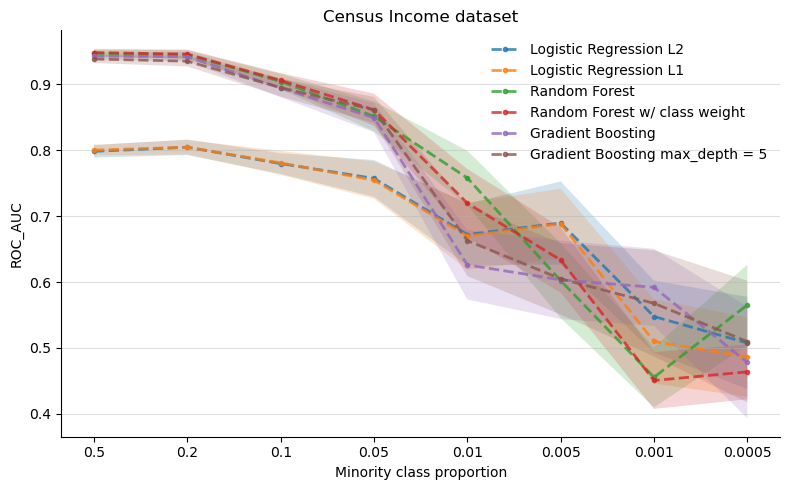

In [275]:
metric_4_display = 'roc_auc'
colors = {'logreg_l2': 'C0',
          'logreg_l1': 'C1',
          'rf': 'C2',
          'rf_2': 'C3',
          'gb': 'C4',
          'gb_2': 'C5'}
f, ax = plt.subplots(dpi = 100, figsize = (8,5))
for model_name, color in colors.items():
    plot_metric_evolution(metrics, model_name, metric_4_display= metric_4_display, color = color, ax = ax)
ax.legend(loc = 'best', frameon = False)
ax.grid(True, axis = 'y', alpha = 0.4)
ax.set_ylabel(metric_4_display.upper())
ax.set_title(f'Census Income dataset')
clean_ax(ax)
f.tight_layout()

Before we go to the next experiment, let us discuss the above results a bit. One interesting conclusion that can be drawn from the above figure is that both versions of the **Logistic Regression** algorithm are the "most stable" ones as the imbalance gets harder. Clearly the more complex models are better at solving the classification problem for the no-imbalance scenario but this advantage gets smaller as the imbalance grows (to the right of the figure). The error regions represent one standard deviation and were computed using the bootstrap technique.

### Income census dataset
Now we can use a real-life dataset and run a similar comparison experiment. For this round we will use the **Income Census** dataset that can be found [here](https://archive-beta.ics.uci.edu/ml/datasets/adult). To force several class imbalance levels we will write a very simple function that accepts the desired imbalance level and performs an undersampling of the positive class (the minority class).

In [276]:
def undersample(X, y, d, random_state=42):
    """
    Constructs a dataset by undersampling the positive class given a certain 
    imbalance ratio

    Parameters
    ----------
    X: pd.DataFrame
    y: pd.Series
    d: float 
        desired imbalance ratio
    random_state: int (default = 42)

    Returns
    -------
    X, y with the desired imbalance ratio
    """
    alpha = - d/(d-1)
    size = int((y==0).sum()*alpha)
    try:
        return (
            np.vstack([X[y==0], pd.DataFrame(X[y==1]).sample(n=size, replace=False, random_state=random_state)]),
            np.hstack([y[y==0], np.array(size*[1])])
        )
    except:
        return X, y

In [277]:
census_feature_names = list(set(census_df_processed.columns).difference(set(['target'])))
X, y = undersample(census_df_processed[census_feature_names], census_df_processed['target'], d = 0.1)

metrics = {}
fit_time = {}
imbalances = [0.2, 0.1, 0.05, 0.01, 5e-3, 2e-3]
random_state = 42
for imbalance in tqdm(imbalances):
    metrics[imbalance] = {}
    # generate imbalanced dataset
    X, y = undersample(census_df_processed[census_feature_names], census_df_processed['target'], d = imbalance)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y)
    
    # Logistic Regression L2
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    metrics[imbalance]['logreg_l2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Logistic Regression L1
    lr_pipeline_2 = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression(penalty= 'l1', solver = 'saga', max_iter = 200))])
    lr_pipeline_2.fit(X_train, y_train)
    y_proba_lr_2 = lr_pipeline_2.predict_proba(X_test)
    metrics[imbalance]['logreg_l1'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr_2[:,1])
    
    # Random Forest
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)
    metrics[imbalance]['rf'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf[:,1])

    # Random Forest class weight
    rf_clf_2 = RandomForestClassifier(class_weight = 'balanced')
    rf_clf_2.fit(X_train, y_train)
    y_proba_rf_2 = rf_clf_2.predict_proba(X_test)
    metrics[imbalance]['rf_2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf_2[:,1])

    # Gradient Boosting Machine
    gb_clf = HistGradientBoostingClassifier()
    gb_clf.fit(X_train, y_train)
    y_proba_gb = gb_clf.predict_proba(X_test)
    metrics[imbalance]['gb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb[:,1])

    # Gradient Boosting Machine with fixed max_depth
    gb_clf_2 = HistGradientBoostingClassifier(max_depth = 5)
    gb_clf_2.fit(X_train, y_train)
    y_proba_gb_2 = gb_clf_2.predict_proba(X_test)
    metrics[imbalance]['gb_2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb_2[:,1])

print('Experiment ended!')

  0%|          | 0/6 [00:00<?, ?it/s]

Minority class proportion: 0.2
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Random Forest w/ class weight...
	Gradient Boosting ...
	Gradient Boosting w/ fixed max depth...
Minority class proportion: 0.1
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Random Forest w/ class weight...
	Gradient Boosting ...
	Gradient Boosting w/ fixed max depth...
Minority class proportion: 0.05
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Random Forest w/ class weight...
	Gradient Boosting ...
	Gradient Boosting w/ fixed max depth...
Minority class proportion: 0.01
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Random Forest w/ class weight...
	Gradient Boosting ...
	Gradient Boosting w/ fixed max depth...
Minority class proportion: 0.005
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Random Forest w/ class weight...
	Gradient Boosting ...
	Gradient Boosting w/ fixed max depth...
Minority class proportion: 0.002
	Log Regression L2 ...
	Log Regression L1 ...


/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


	Random Forest ...
	Random Forest w/ class weight...
	Gradient Boosting ...
	Gradient Boosting w/ fixed max depth...
end


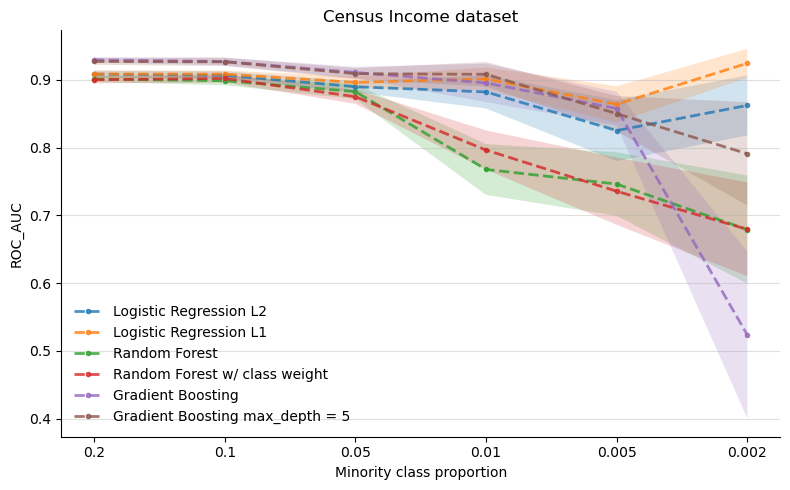

In [279]:
metric_4_display = 'roc_auc'
colors = {'logreg_l2': 'C0',
          'logreg_l1': 'C1',
          'rf': 'C2',
          'rf_2': 'C3',
          'gb': 'C4',
          'gb_2': 'C5'}
f, ax = plt.subplots(dpi = 100, figsize = (8,5))
for model_name, color in colors.items():
    plot_metric_evolution(metrics, model_name, metric_4_display= metric_4_display, color = color, ax = ax)
ax.legend(loc = 'best', frameon = False)
ax.grid(True, axis = 'y', alpha = 0.4)
ax.set_ylabel(metric_4_display.upper())
ax.set_title(f'Census Income dataset')
clean_ax(ax)
plt.show()

The above figure suggests, once again, that both versions of the Logistic Regression are more stable as the class imbalance gets stronger. Morevoer, the L1 regularized logistic regression appears to perform better than its L2 counterpart in regions where imbalance gets more extreme.

### Spam e-mail dataset
The last *real-life* dataset that we will use is related to classifying whether an e-mail is spam or not.

In [289]:
spam_feature_names = set(spam_df.columns).difference(set(['target']))
metrics = {}
imbalances = [0.35, 0.3, 0.2, 0.1, 0.06, 0.01, 0.006]
random_state = 42
for imbalance in tqdm(imbalances):
    metrics[imbalance] = {}
    # generate imbalanced dataset
    X, y = undersample(spam_df[spam_feature_names], spam_df['target'], d = imbalance)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, stratify = y, test_size = 0.4)
    
    # Logistic Regression L2
    lr_pipeline = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression())])
    lr_pipeline.fit(X_train, y_train)
    y_proba_lr = lr_pipeline.predict_proba(X_test)
    metrics[imbalance]['logreg_l2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr[:,1])
    
    # Logistic Regression L1
    lr_pipeline_2 = Pipeline([('scaler', StandardScaler()),
                            ('logreg', LogisticRegression(penalty= 'l1', solver = 'saga', max_iter = 200))])
    lr_pipeline_2.fit(X_train, y_train)
    y_proba_lr_2 = lr_pipeline_2.predict_proba(X_test)
    metrics[imbalance]['logreg_l1'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_lr_2[:,1])
    
    # Random Forest
    rf_clf = RandomForestClassifier()
    rf_clf.fit(X_train, y_train)
    y_proba_rf = rf_clf.predict_proba(X_test)
    metrics[imbalance]['rf'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf[:,1])

    # Random Forest class weight
    rf_clf_2 = RandomForestClassifier(class_weight = 'balanced')
    rf_clf_2.fit(X_train, y_train)
    y_proba_rf_2 = rf_clf_2.predict_proba(X_test)
    metrics[imbalance]['rf_2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_rf_2[:,1])

    # Gradient Boosting Machine
    gb_clf = HistGradientBoostingClassifier()
    gb_clf.fit(X_train, y_train)
    y_proba_gb = gb_clf.predict_proba(X_test)
    metrics[imbalance]['gb'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb[:,1])

    # Gradient Boosting Machine with fixed max_depth
    gb_clf_2 = HistGradientBoostingClassifier(max_depth = 5)
    gb_clf_2.fit(X_train, y_train)
    y_proba_gb_2 = gb_clf_2.predict_proba(X_test)
    metrics[imbalance]['gb_2'] = compute_metrics_bootstrap(y_true = y_test, y_pred = y_proba_gb_2[:,1])

print('Experiment ended!')

  0%|          | 0/7 [00:00<?, ?it/s]

/var/folders/b5/2y0s6nqs0lbf7n8b47ll_3j40000gs/T/ipykernel_41063/2121354437.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X, y = undersample(spam_df[spam_feature_names], spam_df['target'], d = imbalance)
/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/b5/2y0s6nqs0lbf7n8b47ll_3j40000gs/T/ipykernel_41063/2121354437.py:8: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  X, y = undersample(spam_df[spam_feature_names], spam_df['target'], d = imbalance)
/Users/c85538a/anaconda3/envs/ibc/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/var/folders/b5/2y0s6nqs0lbf7n8b47ll_3j40000gs/T

Experiment ended!


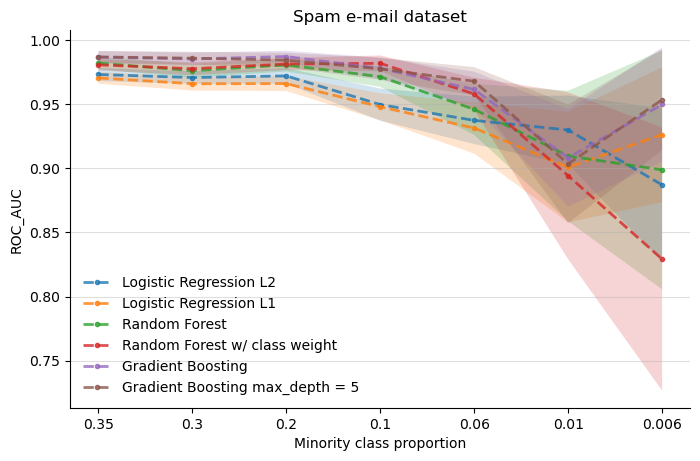

In [290]:
metric_4_display = 'roc_auc'
colors = {'logreg_l2': 'C0',
          'logreg_l1': 'C1',
          'rf': 'C2',
          'rf_2': 'C3',
          'gb': 'C4',
          'gb_2': 'C5'}
f, ax = plt.subplots(dpi = 100, figsize = (8,5))
for model_name, color in colors.items():
    plot_metric_evolution(metrics, model_name, metric_4_display= metric_4_display, color = color, ax = ax)
ax.legend(loc = 'best', frameon = False)
ax.grid(True, axis = 'y', alpha = 0.4)
ax.set_ylabel(metric_4_display.upper())
ax.set_title('Spam e-mail dataset')
clean_ax(ax)
plt.show()

## Conclusions
Both experiments 1 and 2 (synthetic dataset and census income dataset) suggest that a simple Logistic Regression with L1 or L2 regularization mantain a somewhat consistent performance even when the imbalance gets more extreme, as in the case of the synthetic dataset. Both logistic regressions in the last experiment (with spam e-mail data) are the worst performers most of the time, until the imbalance begins to get extreme (0.01). Again, logistic regression appears to have a consistent performance along the imbalance scenarios. Thus, we think it is safe to say that a good baseline model for imbalanced classification problems is a **Logistic Regression**. In some cases L1 or L2 regularization can perform better, and this can depend on the nature of the problem. However, an L1 regularization is advised if we additionally want to perform some feature selection along the modelling process.